In [1]:
import numpy as np
from numba import jit

from py.model import *
from py.scores import *

import pandas as pd
# from SpringRank import SpringRank

from matplotlib import pyplot as plt

from scipy.optimize import root, minimize
from scipy.optimize.slsqp import approx_jacobian
from itertools import product

from autograd import jacobian


import matplotlib
matplotlib.rcParams['font.sans-serif'] = "Arial Unicode MS"

In [2]:
cset = ['#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377']
cset_muted = ['#CC6677', '#332288', '#DDCC77', '#117733', '#88CCEE', '#882255', '#44AA99', '#999933', '#AA4499', '#DDDDDD','#000000']

In [3]:
def compute_gamma(s, beta):
    gamma = np.exp(beta*s)
    gamma = gamma/gamma.sum()
    return(gamma)

def make_s(s_1, s_2, n_1, n):
        
    s_1 = s_1
    s_2 = s_2
    
    n_1 = int(n_1)
    n_2 = n - n_1
    
    s = np.zeros(n)
    s[0:n_1] += 1*s_1
    s[n_1:n] += 1*s_2
#     s = s - (s.sum()-1)/n 
    return(s)

def make_gamma(s_1, s_2, n_1, n, beta):
    s = make_s(s_1, s_2, n_1, n)

    return(compute_gamma(np.sqrt(s), beta)) # for root-degree score

def f(s_1, s_2, n_1, n, beta):
    return(make_s(s_1, s_2, n_1, n) - make_gamma(s_1, s_2, n_1, n, beta))

So, we'd like to organize this calculation in a nicer fashion. One way to do this will be to build up a data frame, sort on certain features, and then group them appropriately. We'll need iterators for n_1 and beta. We'll also need to allow for multiple solutions...

# Compute the space of solutions

In [5]:
BETA_GRID = np.linspace(0, 10, 201)
n_1   = np.arange(1, 8)
rep = np.arange(0, 101)

n = 8

def g(row):
    x0 = np.random.rand(2)
    x0 = x0 / x0.sum()
    res = root(lambda s: f(s[0],s[1], row.n_1, n, row.beta)[[0,n-1],], x0 = x0, tol = 10**(-8))
    if res['success']:
        return(pd.Series(res['x'], index = ['s_1', 's_2']))
    else:
        return(pd.Series([np.nan, np.nan], index = ['s_1', 's_2']))

In [6]:
df = pd.DataFrame(list(product(BETA_GRID, n_1, rep)), columns=['beta', 'n_1', 'rep'])

df = pd.concat([df, df.apply(g, axis = 1, result_type='expand')], axis = 1) # compute a bunch of equilibria
df = df.sort_values(['beta', 'n_1', 's_1'])
df = df[df.s_1.notnull()]
df['s_1'] = np.round(df.s_1, 3)
df['s_2'] = np.round(df.s_2, 3)
df['s1'] = df[['s_1', 's_2']].max(axis = 1)
df['s2'] = df[['s_1', 's_2']].min(axis = 1)
df = df.drop_duplicates(['n_1', 'beta', 's1', 's2'])
df = df.drop(['s_1', 's_2', 'rep'], axis = 1)

df['group'] = df.groupby(['beta', 'n_1'])['s1'].rank(method = 'first')

df = pd.concat([df, df.apply(lambda row: pd.Series(make_s(row.s1, row.s2, row.n_1, n)[[0,-1]], index = ['s_1', 's_2']),
                            result_type = 'expand',
                            axis = 1)],
              axis = 1)
df = df.drop(['s1','s2'], axis = 1)

/Users/philchodrow/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in sqrt


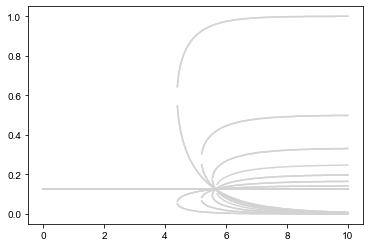

In [7]:
p = df.groupby(['n_1','group' ]).apply(lambda g: plt.plot(g.beta, g.s_1, color = 'lightgrey', zorder = 1))
p = df.groupby(['n_1','group' ]).apply(lambda g: plt.plot(g.beta, g.s_2, color = 'lightgrey', zorder = 1))
# plt.semilogy()

In [7]:
def compute_gamma_(row, power = 1): 
    beta = row.beta
    s_1 = row.s_1
    s_2 = row.s_2
    n_1 = row.n_1
    n_2 = n - n_1
    
    v_1 = np.exp(beta*(s_1**power))
    v_2 = np.exp(beta*(s_2**power))
    
    gamma_1 = np.array(v_1/(n_1*v_1 + n_2*v_2))
    gamma_2 = np.array(v_2/(n_1*v_1 + n_2*v_2))
    
    return(pd.Series([gamma_1, gamma_2], index = ['gamma_1', 'gamma_2']))

df = pd.concat((df, df.apply(compute_gamma_, result_type = 'expand', axis = 1, power = 1/2)), axis = 1)

df = df[np.abs(df.s_1 - df.gamma_1) < .01]

# Compute stability

In [8]:
def jacobian(n_1, s_1, s_2, n, beta):
    s = make_s(s_1, s_2, n_1, n)
    gamma = compute_gamma(s, beta)
    Gamma = np.diag(gamma)
    J = beta/2*(Gamma - np.outer(gamma, gamma)).dot(np.diag(s**(-1/2)))
    return(J)

def test_stable(n_1, s_1, s_2, n, beta):
    J = jacobian(n_1, s_1, s_2, n, beta)
    try:
        stable = np.abs(np.linalg.eig(J)[0]).max() < .98 # bit of a fudge factor for funky numerics
        return(stable)
    except np.linalg.LinAlgError:
        return(False)

In [9]:
df['stable'] = df.apply(lambda row: test_stable(row.n_1, row.s_1, row.s_2, n, row.beta), axis = 1)

# fudge factors for numerical issues in stability calculation

ix = df.s_1 > .8
df.stable[ix] = True

df.stable[(np.abs(df.s_1 - .1) > .005) & (np.abs(df.s_1 - .1) < .5)] = False
df.stable[(df.beta < 2*np.sqrt(10)-.00001) & (np.abs(df.s_1 - .1) < .0000000000000)] = True



# remove some spurious solutions


/Users/philchodrow/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in power
  """
/Users/philchodrow/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/philchodrow/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/philchodrow/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/p

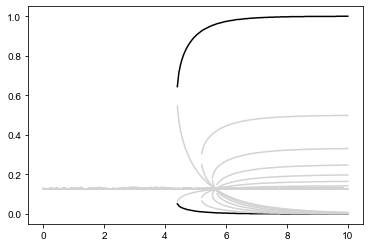

In [12]:
colors = ['lightgrey', 'black']
p = df.groupby(['n_1','group', 'stable']).apply(lambda g: plt.plot(g.beta, g.s_1, zorder = 1, color = colors[int(g.stable.max())]))
p = df.groupby(['n_1','group', 'stable']).apply(lambda g: plt.plot(g.beta, g.s_2, zorder = 1, color = colors[int(g.stable.max())]))

# ix = df.s_1 > .9

# plt.plot(df.beta[ix], df.s_1[ix], zorder = 1, color = 'black')
# plt.plot(df.beta[ix], df.s_2[ix], zorder = 1, color = 'black')

In [13]:
df.to_csv('throughput/degree_score_curves.csv', index = False)